In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType, Normalization

2024-03-25 18:59:00.935132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 18:59:00.935201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 18:59:01.084582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 18:59:01.526331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 18:59:07.041110: W tensorflow/compiler/tf2

In [2]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [4]:
index = [0,3] if MODEL==0 else [1,2]

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)
base_data_train, base_data_test = base_data_train[:,:,index], base_data_test[:,:,index] # 0,3 = th vs air; 1,2 = el vs sky, 6 = month, 7 = winter/summer
print(base_data_train.shape, base_data_test.shape)

(108, 730, 2) (12, 730, 2)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'month']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]
#indicator_var, indicator_var_test = base_data_train[:,:,2], base_data_test[:,:,2]

temp_var = scalers['G.air.T'].fit_transform(temp_var)
energy_var = scalers['G.E_th_I'].fit_transform(energy_var)
#indicator_var = scalers['month'].fit_transform(indicator_var)

temp_var_test = scalers['G.air.T'].fit_transform(temp_var_test)
energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var_test)
#indicator_var_test = scalers['month'].fit_transform(indicator_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


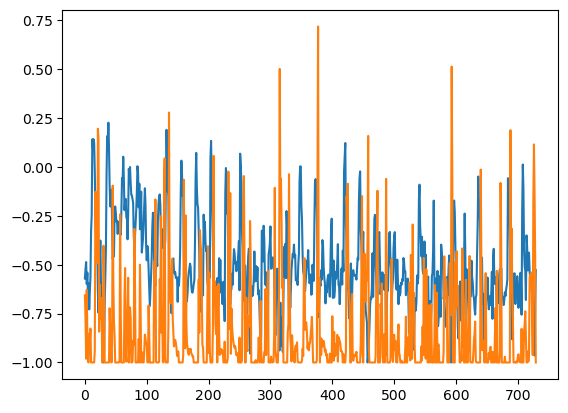

In [7]:
plt.plot(scaled_data_train[10])
plt.show()

In [11]:
attributes = np.random.randint(0, 1, size=(base_data_train.shape[0],1))
features = scaled_data_train.copy()

In [13]:
print(attributes.shape, features.shape)

(108, 1) (108, 730, 2)


In [14]:
# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
model = DGAN(DGANConfig(
    max_sequence_len=scaled_data_train.shape[1],
    sample_len=1,
    batch_size=16,
    epochs=100,  # For real data sets, 100-1000 epochs is typical
))

model.train_numpy(
    attributes=attributes,
    attribute_types = [OutputType.DISCRETE] * 1,
    features=features,
    feature_types = [OutputType.CONTINUOUS] * 2
)

# Generate synthetic data
synthetic_attributes, synthetic_features = model.generate_numpy(1000)

/home/mjmc2/.local/lib/python3.10/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/home/mjmc2/.local/lib/python3.10/site-packages/category_encoders/one_hot.py:187: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
2024-03-25 19:00:00,015 : MainThread : INFO : epoch: 0
2024-03-25 19:00:03,450 : MainThread : INFO : epoch: 1
2024-03-25 19:00:03,990 : MainThread : INFO : epoch: 2
2024-03-25 19:00:04,524 : MainThread : INFO : epoch: 3
2024-03-25 19:00:05,015 : MainThread : INFO : epoch: 4
2024-03-25 19:00:05,501 : MainThread : INFO : epoch: 5
2024-03-25 19:00:05,986 : MainThread : INFO : epoch: 6
2024-03-25 19:00:06,468 : MainThread : INFO : epoch: 7
2024-03-25 19:00:06,965 : MainThread : INFO : epoch: 8
2024-03-25 19:00:07,501 : MainThread 

In [16]:
print(synthetic_attributes.shape, synthetic_features.shape)

(1000, 1) (1000, 730, 2)


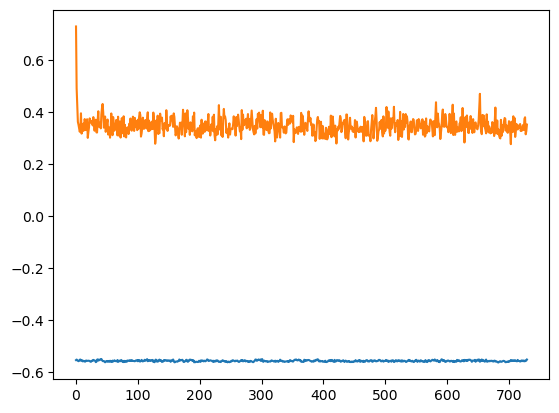

In [19]:
plt.plot(synthetic_features[10])

In [20]:
temp_var, energy_var = synthetic_features[:,:,0],  synthetic_features[:,:,1]
temp_var, energy_var = scalers['G.air.T'].inverse_transform(temp_var), scalers['G.E_']